In [36]:
import pandas as pd
import numpy as np
import warnings
import time

from sktime.datasets import load_arrow_head  # univariate dataset

from sktime.transformations.panel.catch22 import Catch22
from scipy.special import softmax
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sktime.classification.deep_learning.mlp import MLPClassifier
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
epochs = np.arange(1, 51)
last_epoch = 50
fracs = np.arange(10, 101)/100
n_split = 20

2/2 [==============================] - 0s 0s/step


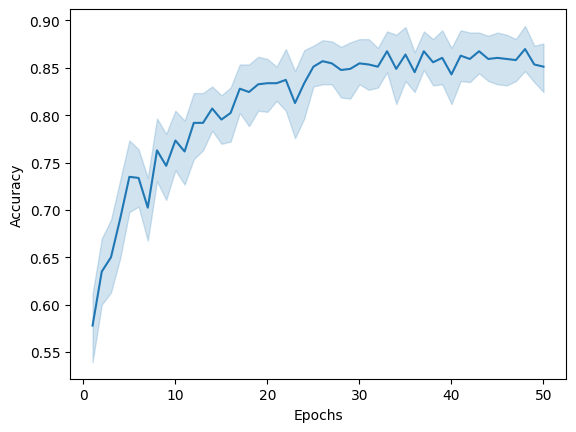

In [38]:
warnings.simplefilter(action='ignore', category=FutureWarning)

data = load_arrow_head(return_X_y=False)
X = data[['dim_0']]
y = data['class_val'].astype('int')

results = pd.DataFrame([], columns=['Epochs', 'Training Time', 'Testing Time', 'Accuracy', 'Balanced Accuracy', 'AUROC_ovr', 'AUROC_ovo'])

i = 0
for epoch in epochs: # increasing the epochs and then increasing the time the model will spend training
    for seed in range(n_split): # averaging the results using 5 different train and test split

        opt = Adam()
        mlp = MLPClassifier(n_epochs=epoch,batch_size=32, optimizer=opt, verbose=False) # initializating the model
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y) # spliting the data using 'i' as random state

        t1 = time.time()
        mlp.fit(X_train, y_train) # training the model
        t1 = time.time() - t1 # measuring the time for each eplit

        t2 = time.time()
        predictions = mlp.predict(X_test) # predicting the test data
        t2 = time.time() - t2 # measuring the test time for each split
        
        predictions_proba = mlp.predict_proba(X_test) # predicting the test data

        # saving the results
        results.loc[i, 'Epochs'] = epoch
        results.loc[i, 'Training Time'] = t1
        results.loc[i, 'Testing Time'] = t2
        results.loc[i, 'Accuracy'] = accuracy_score(y_test, predictions)
        results.loc[i, 'Balanced Accuracy'] = balanced_accuracy_score(y_test, predictions)
        results.loc[i, 'AUROC_ovr'] = roc_auc_score(y_test, predictions_proba, multi_class='ovr')
        results.loc[i, 'AUROC_ovo'] = roc_auc_score(y_test, predictions_proba, multi_class='ovo')
        i += 1

plt.figure()
results.to_csv('output/nn_epoch_increasing.csv', index=False)
results.groupby('Epochs').mean() # calculating the average for each epoch
sns.lineplot(results, x='Epochs', y='Accuracy')
#sns.lineplot(x=range(1, len(mlp.history.history['accuracy'])), y=mlp.history.history['accuracy'])
plt.savefig('output/nn_epoch_increasing.png')
plt.show()

2/2 [==============================] - 0s 3ms/step


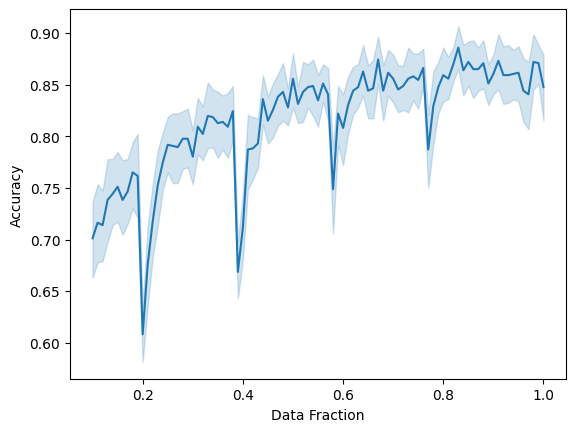

In [77]:
warnings.simplefilter(action='ignore', category=FutureWarning)

results = pd.DataFrame([], columns=['Epochs', 'Training Time', 'Testing Time', 'Accuracy', 'Balanced Accuracy', 'AUROC_ovr', 'AUROC_ovo'])

data = load_arrow_head(return_X_y=False)
X = data[['dim_0']]
y = data['class_val'].astype('int')

i = 0
epoch = last_epoch
for seed in range(n_split): # averaging the results using 5 different train and test split

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y) # spliting the data using 'i' as random state
    
    for frac in fracs: # increasing the epochs and then increasing the time the model will spend training
        try:
            X_train_frac, _, y_train_frac, _ = train_test_split(X_train, y_train, train_size=frac, random_state=seed+1, stratify=y_train)
        except:
            X_train_frac, y_train_frac = X_train, y_train

        opt = Adam()
        mlp = MLPClassifier(n_epochs=epoch,batch_size=32, optimizer=opt, verbose=False) # initializating the model
        
        t1 = time.time()
        mlp.fit(X_train_frac, y_train_frac) # training the model
        t1 = time.time() - t1 # measuring the time for each eplit

        t2 = time.time()
        predictions = mlp.predict(X_test) # predicting the test data
        t2 = time.time() - t2 # measuring the test time for each split
        
        predictions_proba = mlp.predict_proba(X_test) # predicting the test data

        # saving the results
        results.loc[i, 'Data Fraction'] = frac
        results.loc[i, 'Epochs'] = epoch
        results.loc[i, 'Training Time'] = t1
        results.loc[i, 'Testing Time'] = t2
        results.loc[i, 'Accuracy'] = accuracy_score(y_test, predictions)
        results.loc[i, 'Balanced Accuracy'] = balanced_accuracy_score(y_test, predictions)
        results.loc[i, 'AUROC_ovr'] = roc_auc_score(y_test, predictions_proba, multi_class='ovr')
        results.loc[i, 'AUROC_ovo'] = roc_auc_score(y_test, predictions_proba, multi_class='ovo')
        i += 1

plt.figure()
results.to_csv('output/nn_data_increasing.csv', index=False)
results.groupby('Data Fraction').mean() # calculating the average for each epoch
sns.lineplot(results, x='Data Fraction', y='Accuracy')
plt.savefig('output/nn_data_increasing.png')
plt.show()

In [89]:
results = pd.read_csv('output/nn_data_increasing.csv')
results.groupby('Data Fraction').count().iloc[:20]
results.sort_values('Data Fraction').iloc[200:220]

,Epochs,Training Time,Testing Time,Accuracy,Balanced Accuracy,AUROC_ovr,AUROC_ovo,Data Fraction
283,50,1.532999,0.168382,0.651163,0.681750,0.876521,0.875276,0.2
1466,50,1.581808,0.179042,0.627907,0.613876,0.847763,0.843137,0.2
1739,50,1.582361,0.180040,0.511628,0.509804,0.914832,0.909850,0.2
465,50,1.558079,0.171401,0.674419,0.671192,0.912569,0.904571,0.2
1011,50,1.530071,0.169411,0.558140,0.542986,0.825993,0.819063,0.2
374,50,1.574254,0.170432,0.604651,0.594268,0.805028,0.792667,0.2
1193,50,1.579848,0.170348,0.604651,0.570136,0.820865,0.814422,0.2
556,50,1.543583,0.174561,0.627907,0.595777,0.886727,0.875450,0.2
1102,50,1.525537,0.174486,0.627907,0.619910,0.897687,0.891925,0.2
647,50,1.576065,0.180386,0.488372,0.460030,0.816893,0.809375,0.2


<Axes: xlabel='Data Fraction', ylabel='Accuracy'>

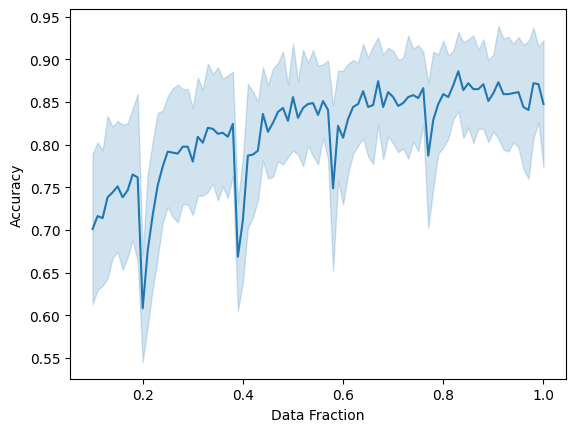

In [94]:
sns.lineplot(results, x='Data Fraction', y='Accuracy', errorbar='sd')

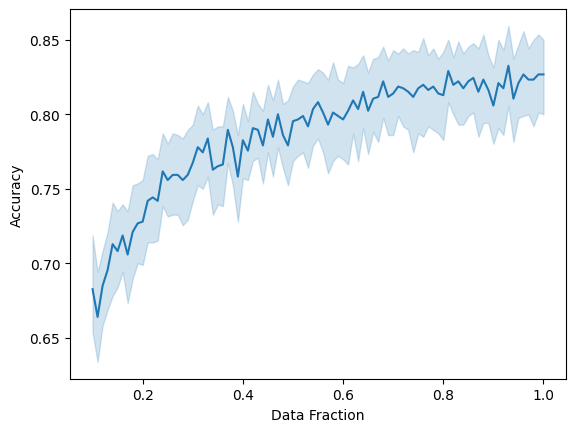

In [76]:
from sklearn.ensemble import RandomForestClassifier

warnings.simplefilter(action='ignore', category=FutureWarning)

results = pd.DataFrame([], columns=['Epochs', 'Training Time', 'Testing Time', 'Accuracy', 'Balanced Accuracy', 'AUROC_ovr', 'AUROC_ovo'])

data = load_arrow_head(return_X_y=False)
X = data[['dim_0']]
y = data['class_val'].astype('int')

i = 0
epoch = last_epoch
for seed in range(n_split): # averaging the results using 5 different train and test split

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y) # spliting the data using 'i' as random state
    
    for frac in fracs: # increasing the epochs and then increasing the time the model will spend training
        try:
            X_train_frac, _, y_train_frac, _ = train_test_split(X_train, y_train, train_size=frac, random_state=seed+1, stratify=y_train)
        except:
            X_train_frac, y_train_frac = X_train, y_train
        
        # Transforming the timeseries to use classic models
        c22_uv = Catch22()        
        c22_uv.fit(X_train_frac, y_train_frac)
        X_train_c22 = c22_uv.transform(X_train_frac)
        X_test_c22 = c22_uv.transform(X_test)
        
        model = RandomForestClassifier()

        t1 = time.time()
        model.fit(X_train_c22, y_train_frac) # training the model
        t1 = time.time() - t1 # measuring the time for each eplit

        t2 = time.time()
        predictions = model.predict(X_test_c22) # predicting the test data
        t2 = time.time() - t2 # measuring the test time for each split
        
        predictions_proba = model.predict_proba(X_test_c22) # predicting the test data

        # saving the results
        results.loc[i, 'Data Fraction'] = frac
        results.loc[i, 'Epochs'] = epoch
        results.loc[i, 'Training Time'] = t1
        results.loc[i, 'Testing Time'] = t2
        results.loc[i, 'Accuracy'] = accuracy_score(y_test, predictions)
        results.loc[i, 'Balanced Accuracy'] = balanced_accuracy_score(y_test, predictions)
        results.loc[i, 'AUROC_ovr'] = roc_auc_score(y_test, predictions_proba, multi_class='ovr')
        results.loc[i, 'AUROC_ovo'] = roc_auc_score(y_test, predictions_proba, multi_class='ovo')
        i += 1

plt.figure()
results.to_csv('output/nn_data_increasing.csv', index=False)
results.groupby('Data Fraction').mean() # calculating the average for each epoch
sns.lineplot(results, x='Data Fraction', y='Accuracy')
plt.savefig('output/c22_rf_data_increasing.png')
plt.show()

C:\Users\marci\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\marci\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

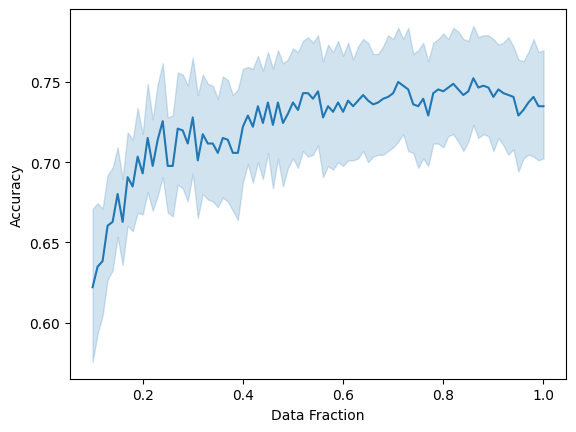

In [75]:
warnings.simplefilter(action='ignore', category=FutureWarning)

results = pd.DataFrame([], columns=['Epochs', 'Training Time', 'Testing Time', 'Accuracy', 'Balanced Accuracy', 'AUROC_ovr', 'AUROC_ovo'])

data = load_arrow_head(return_X_y=False)
X = data[['dim_0']]
y = data['class_val'].astype('int')

i = 0
epoch = last_epoch
for seed in range(n_split): # averaging the results using 5 different train and test split

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y) # spliting the data using 'i' as random state
    
    for frac in fracs: # increasing the epochs and then increasing the time the model will spend training
        try:
            X_train_frac, _, y_train_frac, _ = train_test_split(X_train, y_train, train_size=frac, random_state=seed+1, stratify=y_train)
        except:
            X_train_frac, y_train_frac = X_train, y_train
        
        # Transforming the timeseries to use classic models
        c22_uv = Catch22()        
        c22_uv.fit(X_train_frac, y_train_frac)
        X_train_c22 = c22_uv.transform(X_train_frac)
        X_test_c22 = c22_uv.transform(X_test)

        model = LogisticRegression(max_iter=1000)

        t1 = time.time()
        model.fit(X_train_c22, y_train_frac) # training the model
        t1 = time.time() - t1 # measuring the time for each eplit

        t2 = time.time()
        predictions = model.predict(X_test_c22) # predicting the test data
        t2 = time.time() - t2 # measuring the test time for each split
        
        predictions_proba = model.predict_proba(X_test_c22) # predicting the test data

        # saving the results
        results.loc[i, 'Data Fraction'] = frac
        results.loc[i, 'Epochs'] = epoch
        results.loc[i, 'Training Time'] = t1
        results.loc[i, 'Testing Time'] = t2
        results.loc[i, 'Accuracy'] = accuracy_score(y_test, predictions)
        results.loc[i, 'Balanced Accuracy'] = balanced_accuracy_score(y_test, predictions)
        results.loc[i, 'AUROC_ovr'] = roc_auc_score(y_test, predictions_proba, multi_class='ovr')
        results.loc[i, 'AUROC_ovo'] = roc_auc_score(y_test, predictions_proba, multi_class='ovo')
        i += 1

plt.figure()
results.to_csv('output/nn_data_increasing.csv', index=False)
results.groupby('Data Fraction').mean() # calculating the average for each epoch
sns.lineplot(results, x='Data Fraction', y='Accuracy')
plt.savefig('output/c22_lr_data_increasing.png')
plt.show()

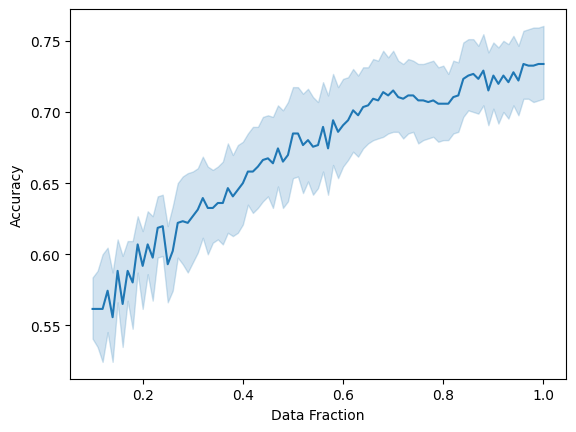

In [74]:
warnings.simplefilter(action='ignore', category=FutureWarning)

results = pd.DataFrame([], columns=['Epochs', 'Training Time', 'Testing Time', 'Accuracy', 'Balanced Accuracy', 'AUROC_ovr', 'AUROC_ovo'])

data = load_arrow_head(return_X_y=False)
X = data[['dim_0']]
y = data['class_val'].astype('int')

i = 0
epoch = last_epoch
for seed in range(n_split): # averaging the results using 5 different train and test split

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y) # spliting the data using 'i' as random state
    
    for frac in fracs: # increasing the epochs and then increasing the time the model will spend training
        try:
            X_train_frac, _, y_train_frac, _ = train_test_split(X_train, y_train, train_size=frac, random_state=seed+1, stratify=y_train)
        except:
            X_train_frac, y_train_frac = X_train, y_train
        
        # Transforming the timeseries to use classic models
        c22_uv = Catch22()        
        c22_uv.fit(X_train_frac, y_train_frac)
        X_train_c22 = c22_uv.transform(X_train_frac)
        X_test_c22 = c22_uv.transform(X_test)

        model = KNeighborsClassifier()

        t1 = time.time()
        model.fit(X_train_c22, y_train_frac) # training the model
        t1 = time.time() - t1 # measuring the time for each eplit

        t2 = time.time()
        predictions = model.predict(X_test_c22) # predicting the test data
        t2 = time.time() - t2 # measuring the test time for each split
        
        predictions_proba = model.predict_proba(X_test_c22) # predicting the test data

        # saving the results
        results.loc[i, 'Data Fraction'] = frac
        results.loc[i, 'Epochs'] = epoch
        results.loc[i, 'Training Time'] = t1
        results.loc[i, 'Testing Time'] = t2
        results.loc[i, 'Accuracy'] = accuracy_score(y_test, predictions)
        results.loc[i, 'Balanced Accuracy'] = balanced_accuracy_score(y_test, predictions)
        results.loc[i, 'AUROC_ovr'] = roc_auc_score(y_test, predictions_proba, multi_class='ovr')
        results.loc[i, 'AUROC_ovo'] = roc_auc_score(y_test, predictions_proba, multi_class='ovo')
        i += 1

plt.figure()
results.to_csv('output/c22_rc_data_increasing.csv', index=False)
results.groupby('Data Fraction').mean() # calculating the average for each epoch
sns.lineplot(results, x='Data Fraction', y='Accuracy')
plt.savefig('output/c22_rc_data_increasing.png')
plt.show()

<Axes: xlabel='Data Fraction', ylabel='Accuracy'>

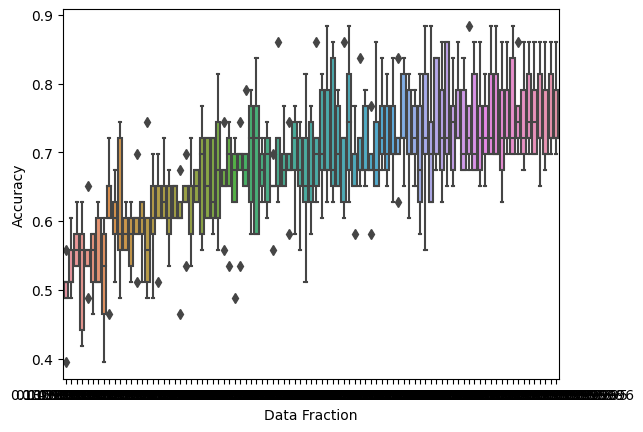

In [ ]:
sns.boxplot(results, x='Data Fraction', y='Accuracy')